# Build a 1-qubit classifier using the library PennyLane

We import PennyLane and the wrapped version of NumPy provided by PennyLane.

In [138]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

Next, we build our quantum device, which is defined as any computational object that can apply quantum operations and return a measurement value.

In [139]:
dev = qml.device("default.qubit", wires=1)
#default.qubit stands for the qubit model for quantum computation and wires=1 means that we use just 1 qubit 

We construct the quantum circuit which describes the quantum function of interest by the decorator *qnode()*, called quantum node. This quantum node is bound to the quantum device, which is used to compute expectation and variance values of the circuit. 

In our case, the 1-qubit classifier (arXiv:1907.02085) is built as a sequence of unitaries describing multiple uploads of the data points and arbitrary single qubit rotations.

In [140]:
@qml.qnode(dev)
def circuit(parameters, x=None, out_dm=None):
    
    #pass the array of parameters, the input vector, and the output density matrix
    
    for par in parameters:
        qml.Rot(*x, wires=0)   #rotation implementing the upload of the data point that acts on the qubit, specified by wires=0 
        qml.Rot(*par, wires=0) #parametrized rotation applied to the qubit state 
    
    #return the expectation value of the output density matrix on the final state
    return qml.expval(qml.Hermitian(out_dm, wires=[0])) 

The above circuit takes a data point, applies all the unitaries, and returns the squared overlap between the final state and the correct label state. 

Before moving on, we need a function to convert a label state into the corrisponding density matrix so that we can feed it into the *circuit*.

In [141]:
def dm(state):
    #takes in a complex state vector |..>
    return state*np.conj(state).T  #return the density matrix |..><..|

We also encode the classes as fixed vectors on the Bloch sphere. Here we deal just with two classes.

In [142]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]

label_states = [label_0, label_1]

Let's see how to compute the fidelity cost function.

In [143]:
def fid_cost(parameters, x_points, y_targets, label_states=None ):
    
    #x_array contains all the data points, y_targets the labels
    
    #convert label states into density matrices
    label_dms = [dm(state) for state in label_states] 
    
    loss = 0.0
    
    #compute the fidelity cost function
    for i in range(len(x_points)): 
        fid =  circuit(parameters, x=x_points[i], out_dm=label_dms[y_targets[i]])
        loss += (1 - fid)**2     
        
    #label_dms[y_targets[i]] is the density matrix corresponding to the data point target     
       
    #we finally return the normalized loss    
    return loss/len(x_points)  
    
   

## Classification of a circle

Following the first example of arXiv:1907.02085, we generate random points on a plane and try to classify these points as outside/inside a circle of given radius. The radius is set to $\sqrt{\frac{2}{\pi}}$ such that the probability of success for a random classification is 50%.

In [144]:
def circle_data(n_points, radius= np.sqrt(2/np.pi)):
    
    x_vals = []
    y_vals = []
    
    #random points in [-1,1] 
    for i in range(n_points):
        x = np.random.rand(2) * 2 - 1 
        y = 0
        
        #check if the data point is inside the circle
        if x[0]**2 + x[1]**2 < radius**2: 
            y = 1
            
        x_vals.append(x)
        y_vals.append(y)
        
    return np.array(x_vals), np.array(y_vals)

In [145]:
def plot_circle(radius=np.sqrt(2/np.pi), fig=None, ax=None, color='black'):
    
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    # theta from 0 to 2pi
    theta = np.linspace(0, 2*np.pi, 100)

    #radius of the circle
    r = radius

    # compute x1 and x2
    x1 = r*np.cos(theta)
    x2 = r*np.sin(theta)
    
    ax.plot(x1,x2, color=color) 

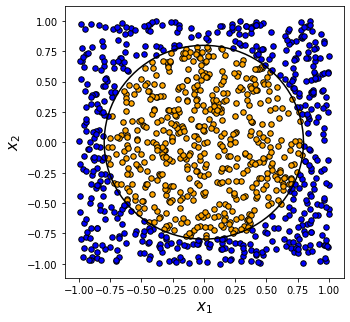

In [146]:

def plot_data(x, y, fig=None, ax=None, title=None):
        
    orange = y==1
    blue = y==0
    
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    
    ax.scatter(x[orange,0], x[orange,1], s=30, c='orange', edgecolor='k')
    ax.scatter(x[blue,0], x[blue,1], s=30, c='blue', edgecolor='k')
    
    ax.set_xlabel('$x_1$',size=15)
    ax.set_ylabel('$x_2$',size=15)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    ax.set_title(title,size=15)
    

x_points, y_points = circle_data(1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_data(x_points, y_points, fig, ax)
plot_circle(fig=fig, ax=ax)
plt.show()

Let's generate the train and test datasets.

In [147]:
#numbers of samples from arXiv:1907.02085
train_samples = 200
test_samples = 4000

x_set, y_train = circle_data(train_samples)
x_train = np.concatenate( (x_set, np.zeros((x_set.shape[0], 1))), axis=1) #we pad the third dimension with zeros

x_set1, y_test = circle_data(test_samples)
x_test = np.concatenate( (x_set1, np.zeros((x_set1.shape[0], 1))), axis=1) #we pad the third dimension with zeros


Let's build a function to compute predictions and accuracies.

In [148]:
def predict(parameters, x_points, label_states=None):
    
    label_dms = [dm(state) for state in label_states]
    
    predictions = []
    
    for i in range(len(x_points)):
        func = lambda v: circuit(parameters, x=x_points[i], out_dm=v)
        fidelities = [ func(dm) for dm in label_dms]
        best_fid = np.argmax(fidelities)
        predictions.append(best_fid)
    
    return np.array(predictions)   

def accuracy(y_targets, y_predicted):
    
    score = y_predicted == y_targets
    accur = score.sum() / len(y_targets)
    
    return accur

To optimize the fidelity cost function we use *AdamOptimizer*.

In [149]:
from pennylane.optimize import AdamOptimizer

#define number of epochs, batch_size and numbers of layers
epochs=10
batch_size = 20
num_layers = [2,4]

Let's train the classifier with different numbers of layers.

In [150]:
losses=[]
accuracies=[]
predictions = []

for layers in num_layers:
    
    #instantiate the optimizer
    opt = AdamOptimizer(stepsize=0.2, beta1=0.9, beta2=0.99)
    
    #initial random parameters 
    parameters = np.random.uniform(size=(layers, 3))
    print('\n\nClassifier with {} layer(s)\n'.format(layers))
    
    for i in range(epochs):
        #generate batches of batch_size
        for j in range(0, len(x_train) - batch_size + 1, batch_size):
            parameters = opt.step(lambda p: fid_cost(p, x_train[j:j+batch_size], y_train[j:j+batch_size], label_states), parameters)
    
        y_train_predicted = predict(parameters, x_train, label_states)
        accuracy_train = accuracy(y_train, y_train_predicted)
        loss_train = fid_cost(parameters, x_train, y_train, label_states)
    
        y_test_predicted = predict(parameters, x_test, label_states)
        accuracy_test = accuracy(y_test, y_test_predicted)
        loss_test = fid_cost(parameters, x_test, y_test, label_states)
    
        print('Epoch: {:2d} | Train loss: {:3f} | Train accuracy:  {:3f} | Test loss: {:3f} | Test accuracy: {:3f}'.format(i+1, loss_train, accuracy_train, loss_test, accuracy_test))    
    
    print('\nSuccess rate with {} layers: {:3f}'.format(layers, accuracy_test))
    accuracies.append([accuracy_train, accuracy_test])
    losses.append([loss_train, loss_test])
    predictions.append(y_test_predicted)



Classifier with 2 layer(s)

Epoch:  1 | Train loss: 0.249822 | Train accuracy:  0.575000 | Test loss: 0.243888 | Test accuracy: 0.590000
Epoch:  2 | Train loss: 0.176304 | Train accuracy:  0.820000 | Test loss: 0.174979 | Test accuracy: 0.804750
Epoch:  3 | Train loss: 0.184483 | Train accuracy:  0.780000 | Test loss: 0.183969 | Test accuracy: 0.775750
Epoch:  4 | Train loss: 0.178117 | Train accuracy:  0.820000 | Test loss: 0.178242 | Test accuracy: 0.803500
Epoch:  5 | Train loss: 0.177163 | Train accuracy:  0.835000 | Test loss: 0.176874 | Test accuracy: 0.811000
Epoch:  6 | Train loss: 0.175896 | Train accuracy:  0.840000 | Test loss: 0.174829 | Test accuracy: 0.814000
Epoch:  7 | Train loss: 0.175943 | Train accuracy:  0.840000 | Test loss: 0.174960 | Test accuracy: 0.814750
Epoch:  8 | Train loss: 0.175629 | Train accuracy:  0.840000 | Test loss: 0.174389 | Test accuracy: 0.814750
Epoch:  9 | Train loss: 0.175871 | Train accuracy:  0.840000 | Test loss: 0.175054 | Test accuracy

Let's finally plot the results.

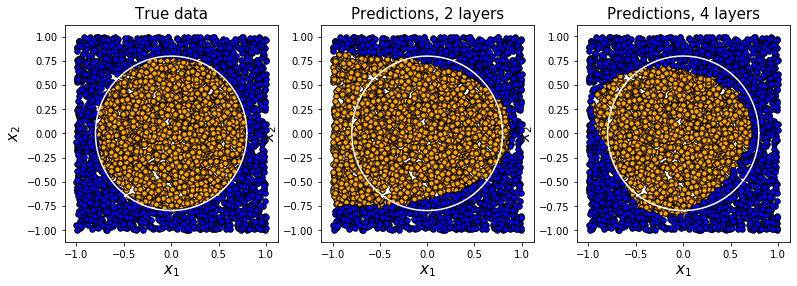

In [151]:
fig, axes = plt.subplots(1,3, figsize=(13,4))

plot_data(x_test, y_test, fig, axes[0], title='True data')
plot_circle(fig=fig, ax=axes[0], color='white')

plot_data(x_test, predictions[0], fig, axes[1], title='Predictions, {} layers'.format(num_layers[0]))
plot_circle(fig=fig, ax=axes[1], color='white')

plot_data(x_test, predictions[1], fig, axes[2], title='Predictions, {} layers'.format(num_layers[1]))
plot_circle(fig=fig, ax=axes[2], color='white')

plt.show()

Let's compare our success rates to those of the paper.

In [161]:
print('               2 layers   4 layers\nOur results:     81%        88%\nPaper results:   85%        90%')

               2 layers   4 layers
Our results:     81%        88%
Paper results:   85%        90%


We see that our classifier performs fairly well on the circle problem!